# HW07 - Instrumental Variables (due 16 Nov 2023)

In this homework you will practice with running IV regressions with python. You will investigate once more the effect of schooling on earnings, but this time the instrument for education you will use is college proximity to individuals houses (reference paper by [Card, 1993](https://davidcard.berkeley.edu/papers/geo_var_schooling.pdf)).

More in detail, there are two instruments that can be exploited in this context. Both are binary variables taking value 1 if either a 2-years or 4-years college is present in the area where the individual lives.

In [14]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

from linearmodels.iv import IV2SLS
from statsmodels.iolib.summary2 import summary_col
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

df = pd.read_stata('http://www.stata.com/data/jwooldridge/eacsap/card.dta')
pd.read_stata('http://www.stata.com/data/jwooldridge/eacsap/card.dta', iterator=True).variable_labels()

{'id': '',
 'nearc2': '=1 if near 2 yr college, 1966',
 'nearc4': '=1 if near 4 yr college, 1966',
 'educ': 'years of schooling, 1976',
 'age': 'in years',
 'fatheduc': "father's schooling",
 'motheduc': "mother's schooling",
 'weight': 'NLS sampling weight, 1976',
 'momdad14': '=1 if live with mom, dad at 14',
 'sinmom14': '=1 if with single mom at 14',
 'step14': '=1 if with step parent at 14',
 'reg661': 'regional dummy, 1966',
 'reg662': '',
 'reg663': '',
 'reg664': '',
 'reg665': '',
 'reg666': '',
 'reg667': '',
 'reg668': '',
 'reg669': '',
 'south66': '=1 if in south in 1966',
 'black': '=1 if black',
 'smsa': '=1 in in SMSA, 1976',
 'south': '=1 if in south, 1976',
 'smsa66': '=1 if in SMSA, 1966',
 'wage': 'hourly wage in cents, 1976',
 'enroll': '=1 if enrolled in school, 1976',
 'kww': 'knowledge world of work score',
 'iq': 'IQ score',
 'married': '=1 if married, 1976',
 'libcrd14': '=1 if lib. card in home at 14',
 'exper': 'age - educ - 6',
 'lwage': 'log(wage)',
 'expe

In [15]:
df.head()

,id,nearc2,nearc4,educ,age,fatheduc,motheduc,weight,momdad14,sinmom14,...,smsa66,wage,enroll,kww,iq,married,libcrd14,exper,lwage,expersq
0,2,0,0,7,29,NaN,NaN,158413.0,1,0,...,1,548,0,15.0,NaN,1.0,0.0,16,6.306275,256
1,3,0,0,12,27,8.0,8.0,380166.0,1,0,...,1,481,0,35.0,93.0,1.0,1.0,9,6.175867,81
2,4,0,0,12,34,14.0,12.0,367470.0,1,0,...,1,721,0,42.0,103.0,1.0,1.0,16,6.580639,256
3,5,1,1,11,27,11.0,12.0,380166.0,1,0,...,1,250,0,25.0,88.0,1.0,1.0,10,5.521461,100
4,6,1,1,12,34,8.0,7.0,367470.0,1,0,...,1,729,0,34.0,108.0,1.0,0.0,16,6.591674,256


### OLS

<Axes: xlabel='educ', ylabel='lwage'>

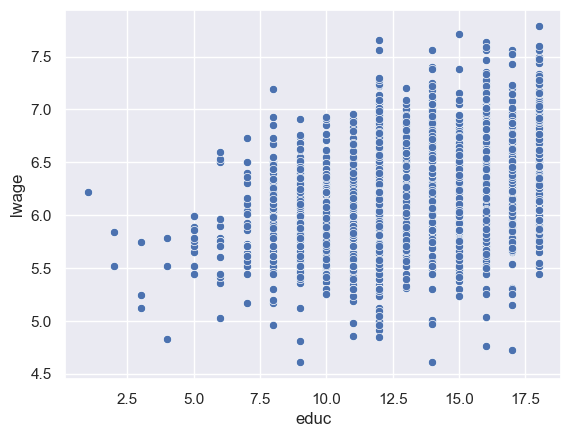

In [16]:
##plot log wages against education
sns.set_theme()
sns.scatterplot(x='educ',y='lwage',data=df)



In [17]:
##Regress log wages (lwage) against educ and include controls, use robust standard errors.

covariates = ['wage','age','fatheduc','motheduc','momdad14','sinmom14','step14','married','iq','exper','expersq']
df = df.dropna(subset=['lwage', 'educ']+covariates)
y = df['lwage']
X_term = sm.add_constant(df[['educ'] + covariates])
ols = sm.OLS(y,X_term)
res = ols.fit(cov_type='HC3')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                 3.749e+05
Date:                Mon, 13 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:02:48   Log-Likelihood:                 979.02
No. Observations:                1618   AIC:                            -1934.
Df Residuals:                    1606   BIC:                            -1869.
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4183      0.004    106.388      0.0

**What are other possible confunders?**

Other possible confounders could include parental wealth and occupation, which could impact the child's education and career path. Another confounder that could impact both the treatment and outcome could be the current economic conditions. This could impact how many years someone could afford to go to school, and also impact the types of jobs available.  

### 2SLS

You will use only on proximity to a 4-years college ($nearc4$) as instrument. 

<Axes: xlabel='nearc4', ylabel='lwage'>

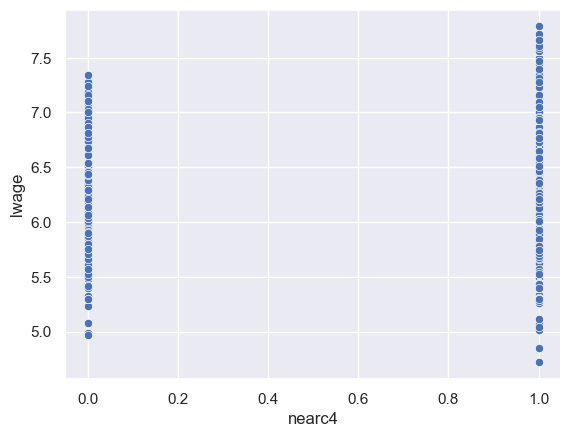

In [18]:
##plot log wages against nearc4
sns.set_theme()
sns.scatterplot(x='nearc4',y='lwage',data=df)


<Axes: xlabel='nearc4', ylabel='educ'>

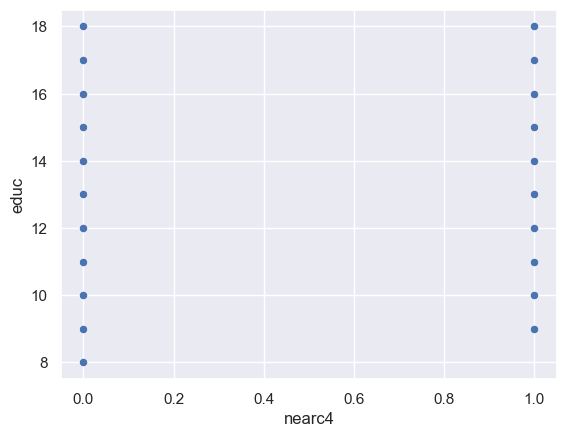

In [19]:
##plot education against nearc4
sns.set_theme()
sns.scatterplot(x='nearc4',y='educ',data=df)

**If you run an IV regression of log wages on education, using college proximity as an instrument for education, what would you expect the sign of the coefficient on education to be? Why?**
Positive, because the education should still have a positive impact on the log wages, even when using college proximity as an instrument. 


In [20]:
##run a regression of education on nearc4, adding the controls you selected before and using robust standard errors
fs = covariates = ['wage','age','fatheduc','motheduc','momdad14','sinmom14','step14','married','iq','exper','expersq']
df = df.dropna(subset=['nearc4', 'educ']+covariates)
y = df['nearc4']
X_term = sm.add_constant(df[['educ'] + covariates])
ols2 = sm.OLS(y,X_term)
res2 = ols2.fit(cov_type='HC3')
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:                 nearc4   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     362.2
Date:                Mon, 13 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:02:49   Log-Likelihood:                -1000.7
No. Observations:                1618   AIC:                             2025.
Df Residuals:                    1606   BIC:                             2090.
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0273      0.015      1.849      0.0

In [21]:
##predict education from the previous regression
df['educhat'] = res.predict(X_term)

In [22]:
##run a regression of log wages on education and controls using robust standard errors
##run a regression of education on nearc4, adding the controls you selected before and using robust standard errors
fs = covariates = ['wage','age','fatheduc','motheduc','momdad14','sinmom14','step14','married','iq','exper','expersq']
df = df.dropna(subset=['lwage', 'educhat']+covariates)
y = df['lwage']
X_term = sm.add_constant(df[['educhat'] + covariates])
twosls = sm.OLS(y,X_term)
res3 = twosls.fit(cov_type='HC3')
print(res3.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                 3.749e+05
Date:                Mon, 13 Nov 2023   Prob (F-statistic):               0.00
Time:                        14:02:49   Log-Likelihood:                 979.02
No. Observations:                1618   AIC:                            -1934.
Df Residuals:                    1606   BIC:                            -1869.
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1778      0.002    108.269      0.0

In [23]:
##compare the 2sls and ols estimates 
print(summary_col([res, res3], float_format='%0.3f', info_dict={'N': lambda x: "{0:d}".format(int(x.nobs))}, regressor_order=['educ', 'educhat']))


               lwage I lwage II
-------------------------------
educ           -0.837          
               (0.008)         
educhat                0.967   
                       (0.009) 
age            0.835   -0.000  
               (0.007) (0.002) 
const          0.418   0.178   
               (0.004) (0.002) 
exper          -0.838  -0.000  
               (0.010) (0.004) 
expersq        0.000   0.000   
               (0.000) (0.000) 
fatheduc       -0.004  -0.000  
               (0.001) (0.001) 
iq             0.001   0.000   
               (0.000) (0.000) 
married        -0.008  -0.000  
               (0.002) (0.002) 
momdad14       -0.043  -0.001  
               (0.018) (0.018) 
motheduc       0.004   0.000   
               (0.002) (0.002) 
sinmom14       -0.031  -0.001  
               (0.059) (0.059) 
step14         -0.066  -0.002  
               (0.027) (0.027) 
wage           0.001   0.000   
               (0.000) (0.000) 
R-squared      0.900   0.900   
R-squar

**What do you think the difference in the estimates is due to?**
The difference in these estimates is due to not taking the instrumental variable into account in the first regression, hurting the exogeneity.

### IV analysis

In [41]:
##use IV2sls to run the regression of log wages on education. using college proximity as an instrument for education
##add the same controls as 
from linearmodels import IV2SLS
exog = sm.add_constant(df[covariates])
inst = df['nearc4']
iv2sls = IV2SLS(exog=exog,endog=df['lwage'],instruments=inst,dependent=df['educ']).fit()
print(iv2sls.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                   educ   R-squared:                      1.0000
Estimator:                    IV-2SLS   Adj. R-squared:                 1.0000
No. Observations:                1618   F-statistic:                 1.333e+17
Date:                Mon, Nov 13 2023   P-value (F-stat)                0.0000
Time:                        14:13:57   Distribution:                 chi2(12)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -6.0000  3.296e-05 -1.821e+05     0.0000     -6.0001     -5.9999
wage       -1.455e-10   8.96e-09    -0.0162     0.98